In [200]:
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imread
import cv2
from skimage import color
import numpy.linalg as la
import os
import shutil
from tqdm import tqdm
import pickle
import time

In [201]:
def generate_superpixels_sklearn(image_path, k):

    # load the image
    image = imread(image_path)

    # apply SLIC and obtain segment labels
    segments = slic(image, n_segments=k, compactness=10,
                    sigma=1, start_label=1)

    # create an image showing the superpixel boundaries
    superpixels = label2rgb(segments, image, kind='avg')

    # display the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(superpixels)
    ax[1].set_title(f'Superpixels with k={k}')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

    return superpixels


In [202]:
test_path = './logo-dataset/volkswagen/images/'


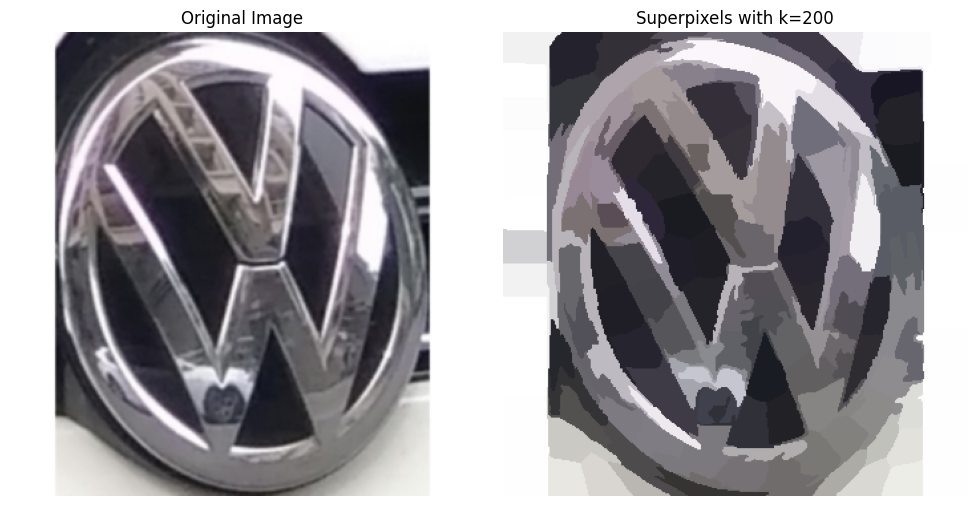

array([[[241, 241, 242],
        [241, 241, 242],
        [241, 241, 242],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[241, 241, 242],
        [241, 241, 242],
        [241, 241, 242],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[241, 241, 242],
        [241, 241, 242],
        [241, 241, 242],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

In [203]:
generate_superpixels_sklearn('./smaller-logo-dataset/volkswagen/1e886e5be7bd5a7c1b4a1187dfea925a1fdeb859.png', 200)


In [204]:
def calculate_gradient_sobel(image):
    # grayscale image
    if len(image.shape) > 2:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    # calculate the gradients using sobel and cv2.CV_64F
    grad_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    # calc gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # normalize
    gradient_magnitude_norm = cv2.normalize(
        gradient_magnitude, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    return gradient_magnitude_norm


In [205]:
def get_optimized_cluster_centers(image, K):
    height, width = image.shape[:2]
    S = int(np.sqrt(height * width / K))
    cluster_centers = []

    # compute gradient using sobel
    gradient = calculate_gradient_sobel(image)

    for i in range(0, height - S, S):
        for j in range(0, width - S, S):
            center_i, center_j = i + S // 2, j + S // 2

            # neighborhood around the tentative center
            neighborhood_size = S // 4
            min_pos = (center_i, center_j)
            min_gradient = gradient[center_i, center_j]

            for ni in range(max(0, center_i - neighborhood_size), min(height, center_i + neighborhood_size + 1)):
                for nj in range(max(0, center_j - neighborhood_size), min(width, center_j + neighborhood_size + 1)):
                    if gradient[ni, nj] < min_gradient:
                        min_gradient = gradient[ni, nj]
                        min_pos = (ni, nj)

            cluster_centers.append(min_pos)

    # plt.imshow(gradient, cmap='plasma')
    # plt.colorbar()  # Show gradient magnitude scale
    # plt.scatter([c[1] for c in cluster_centers], [c[0]
    #             for c in cluster_centers], color='red')  # mark cluster centers
    # plt.show()

    return cluster_centers, gradient


In [207]:
def slic_superpixels(image, K, m, num_iterations=3):

    # convert image to LAB
    lab_image = color.rgb2lab(image)

    height, width = image.shape[:2]

    N = height * width  # total number of pixels in the image
    A = N / K           # area of superpixel
    S = int(np.sqrt(A))  # length of each superpixel

    cluster_centers, gradient = get_optimized_cluster_centers(image, K)

    # initialize labels and distances
    labels = -1 * np.ones(image.shape[:2], np.int32)
    distances = np.inf * np.ones(image.shape[:2], np.float64)

    spatial_scale = m/S

    # SLIC algorithm
    for _ in range(num_iterations):
        for ci, center in enumerate(cluster_centers):
            cx, cy = center
            # search in 2S range
            for i in range(max(0, cx - S), min(height, cx + S)):
                for j in range(max(0, cy - S), min(width, cy + S)):
                    
                    d_lab = math.dist(lab_image[cx, cy], lab_image[i, j])
                    d_spatial = math.dist([cx, cy], [i, j])

                    d = d_lab + spatial_scale * d_spatial

                    if d < distances[i, j]:
                        distances[i, j] = d
                        labels[i, j] = ci

        # update cluster centers
        for ci in range(len(cluster_centers)):
            members = np.where(labels == ci)
            if members[0].size > 0:
                new_center_x = np.mean(members[0])
                new_center_y = np.mean(members[1])
                cluster_centers[ci] = (
                    int(new_center_x), int(new_center_y))

        # # view image at each iteration
        # curr_image = np.zeros_like(image)
        # # show curr image
        # for ci in range(len(cluster_centers)):
        #     members = np.where(labels == ci)
        #     if members[0].size > 0:
        #         for channel in range(3):
        #             curr_image[members[0], members[1], channel] = np.mean(
        #                 image[members[0], members[1], channel])
        
        # plt.figure()
        # plt.imshow(curr_image)
        # plt.show()

    final_image = np.zeros_like(image)

    # reconstruct superpixelated image
    for ci in range(len(cluster_centers)):
        members = np.where(labels == ci)
        if members[0].size > 0:
            for channel in range(3):
                final_image[members[0], members[1], channel] = np.mean(image[members[0], members[1], channel])

    return final_image
    # return final_image, labels, cluster_centers, gradient

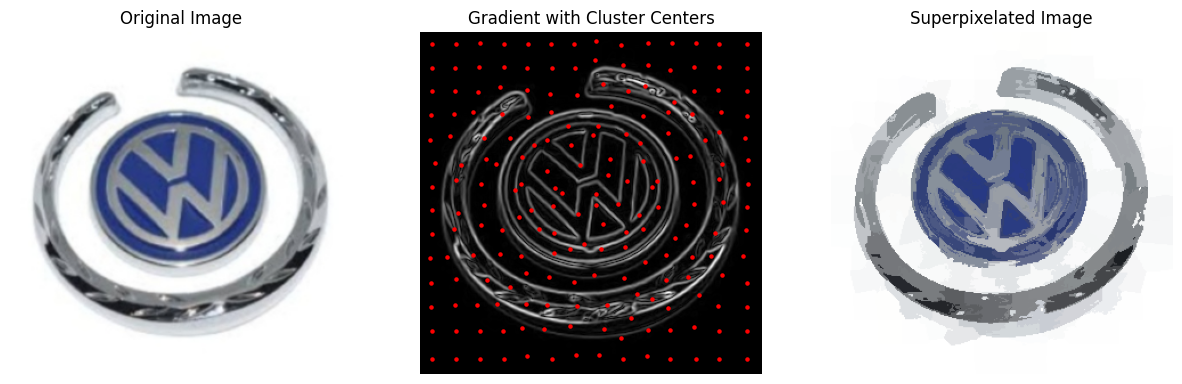

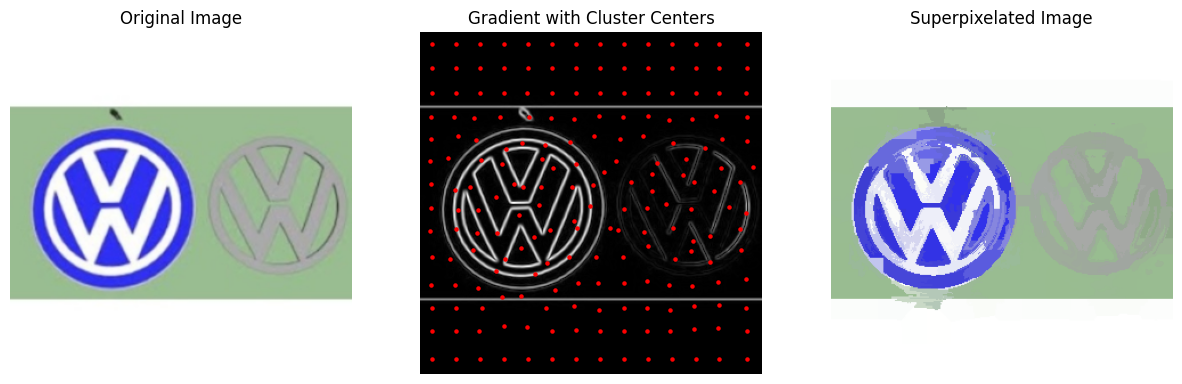

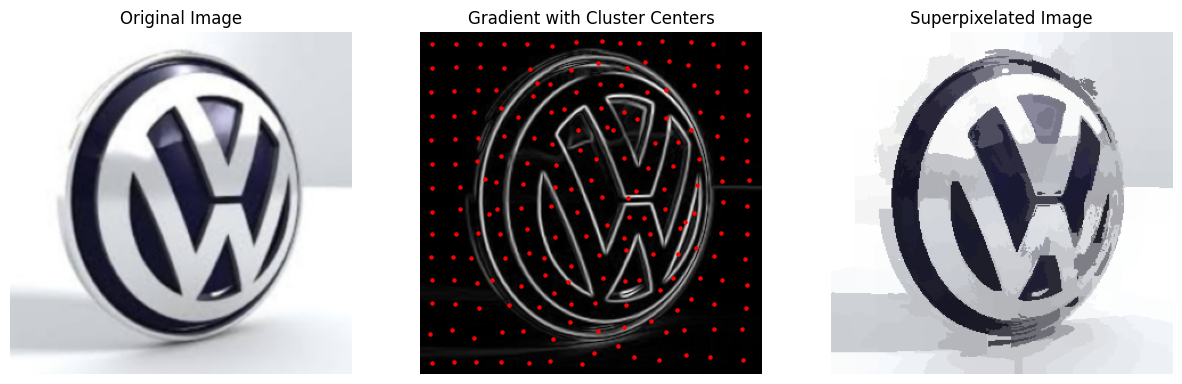

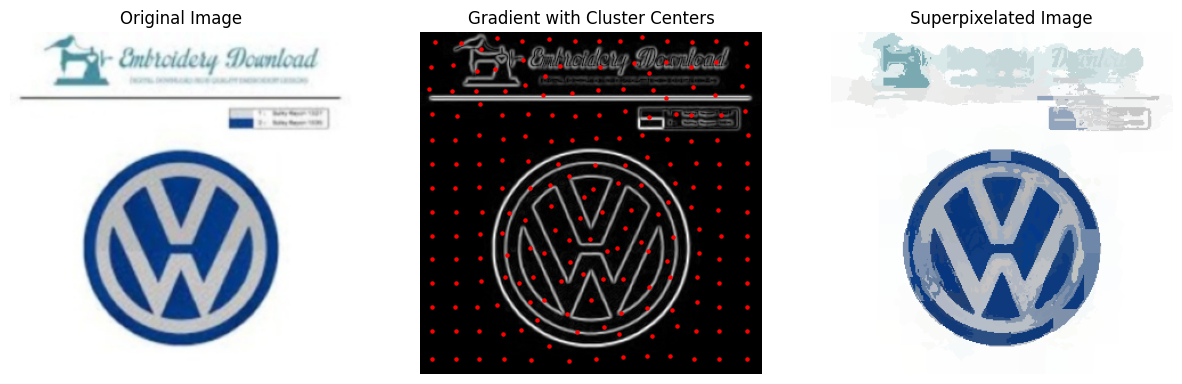

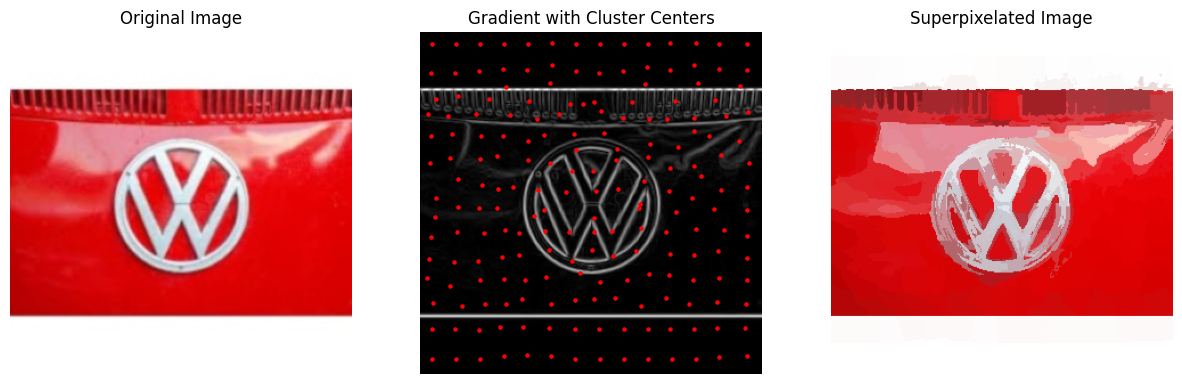

In [198]:
for root, dirs, files in os.walk('./smaller-logo-dataset-300/volkswagen/'):
    np.random.seed(5)
    for file in np.random.choice(files, 5, replace=False):
        img_path = os.path.join(root, file)
        image = cv2.imread(img_path)
        if image is not None:  # ensure image exists
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            final_img, superpixels, cluster_centers_final, img_gradient = slic_superpixels(
                image, K=200, m=2)

            fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 cols

            # display the original image
            ax[0].imshow(image)
            ax[0].set_title("Original Image")
            ax[0].axis('off')

            # display the gradient image with final cluster centers
            ax[1].imshow(img_gradient, cmap='gray')
            ax[1].scatter([y for x, y in cluster_centers_final], [
                          x for x, y in cluster_centers_final], color='red', s=5)  # plotting the cluster centers
            ax[1].set_title("Gradient with Cluster Centers")
            ax[1].axis('off')

            # display the superpixelated image
            ax[2].imshow(final_img)
            ax[2].set_title("Superpixelated Image")
            ax[2].axis('off')

            plt.show()
        else:
            print(f"Failed to load image: {img_path}")


In [208]:
dataset_path = './smaller-logo-dataset-300'
model_training_path = './smaller-keras-dataset-300'

# iterate through each brand's folder
for brand_folder in tqdm(os.listdir(dataset_path)):
    orig_brand_path = os.path.join(dataset_path, brand_folder)
    images_path = orig_brand_path
    slic_images_path = os.path.join(model_training_path, brand_folder)

    if os.path.isdir(images_path):
        # ensure slic_images directory exists
        if not os.path.exists(slic_images_path):
            os.makedirs(slic_images_path)

        # Iterate through each image in the images folder
        for image_name in os.listdir(images_path):
            # save the processed image
            slic_image_name = f"slic_{image_name}"
            slic_image_path = os.path.join(slic_images_path, slic_image_name)

            if os.path.exists(slic_image_path): # don't repeat
                continue

            formatted_image_name = image_name.replace(' ', '_')
            # add slic_ prefix
            slic_image_name = f"slic_{formatted_image_name}"
            slic_image_path = os.path.join(slic_images_path, slic_image_name)

            if os.path.exists(slic_image_path): # don't repeat
                continue

            img_path = os.path.join(images_path, image_name)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Failed to load image: {img_path}")
                continue

            # do slic superpixel image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            final_img = slic_superpixels(image, K=200, m=2)

            # save superpixelated image
            cv2.imwrite(slic_image_path, cv2.cvtColor(
                final_img, cv2.COLOR_RGB2BGR))
            
            # print(f'Processed {slic_image_path}')
    
    print(f"Processed {brand_folder}")

print("Processing complete.")


  6%|▋         | 1/16 [03:25<51:15, 205.05s/it]

Processed volkswagen


 12%|█▎        | 2/16 [04:24<27:52, 119.45s/it]

Processed ford
Processed .DS_Store


 25%|██▌       | 4/16 [05:19<12:19, 61.64s/it] 

Processed jeep


 31%|███▏      | 5/16 [08:49<19:45, 107.80s/it]

Processed mazda


 38%|███▊      | 6/16 [09:57<15:53, 95.39s/it] 

Processed tesla


 44%|████▍     | 7/16 [12:12<16:07, 107.48s/it]

Processed hyundai


 50%|█████     | 8/16 [13:18<12:39, 94.91s/it] 

Processed kia


 56%|█████▋    | 9/16 [15:44<12:52, 110.33s/it]

Processed mercedes


 62%|██████▎   | 10/16 [16:47<09:37, 96.22s/it]

Processed chevrolet


 69%|██████▉   | 11/16 [19:38<09:52, 118.56s/it]

Processed toyota


 75%|███████▌  | 12/16 [20:41<06:47, 101.78s/it]

Processed acura


 81%|████████▏ | 13/16 [23:30<06:06, 122.23s/it]

Processed lexus


 88%|████████▊ | 14/16 [24:35<03:29, 104.86s/it]

Processed alfa


 94%|█████████▍| 15/16 [25:43<01:33, 93.74s/it] 

Processed bmw


100%|██████████| 16/16 [26:47<00:00, 100.47s/it]

Processed honda
Processing complete.


In [170]:
import tensorflow as tf
from keras import layers, models

# Path to your dataset
dataset_path = './smaller-keras-dataset'

In [171]:
# Load data
batch_size = 32
img_height = 400
img_width = 400

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'  # Use 'categorical' for multi-class labels
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)


Found 1374 files belonging to 15 classes.
Using 1100 files for training.
Found 1374 files belonging to 15 classes.
Using 274 files for validation.


In [175]:
num_classes = len(train_ds.class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer after pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Another dropout layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # And another one
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Higher dropout rate before the final layer
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [176]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.0632 - loss: 5.8930 - val_accuracy: 0.1131 - val_loss: 2.6525
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1191 - loss: 2.6391 - val_accuracy: 0.1204 - val_loss: 2.5993
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1452 - loss: 2.5751 - val_accuracy: 0.2737 - val_loss: 2.4370
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 983ms/step - accuracy: 0.2685 - loss: 2.2994 - val_accuracy: 0.3686 - val_loss: 2.1078
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 925ms/step - accuracy: 0.3950 - loss: 1.8682 - val_accuracy: 0.4781 - val_loss: 1.7989
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 926ms/step - accuracy: 0.5206 - loss: 1.4454 - val_accuracy: 0.5511 - val_loss: 1.5635
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 965ms/step - accuracy: 0.6574 - loss: 1.1173 - val_accuracy: 0.5620 - val_loss: 1.5878
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 954ms/step - accuracy: 0.6913 - loss: 0.9418 - val_accuracy: 0.5

In [177]:
model.save('./15_classes_65_pct_acc.keras')

# Save the history
with open('./15_classes_65_pct_history', 'wb') as f:
    pickle.dump(history.history, f)

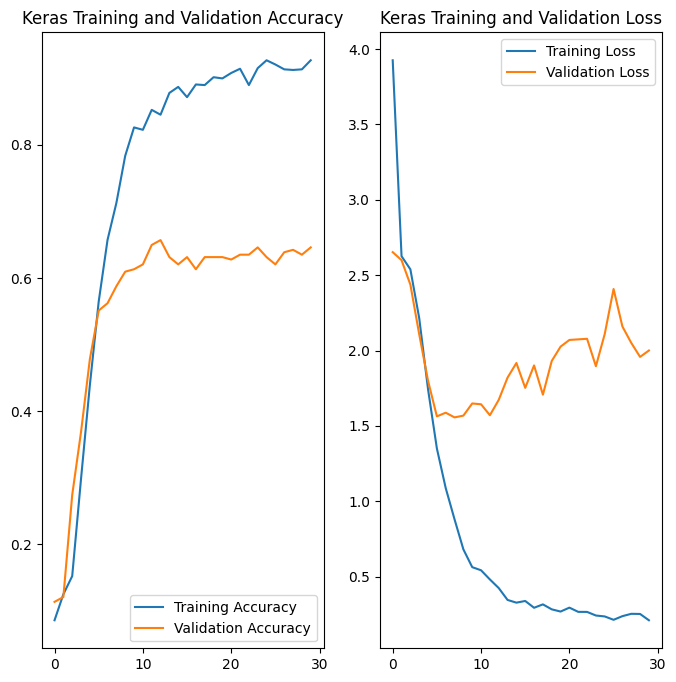

In [178]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Keras Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Keras Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-04-02 18:40:19.570722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


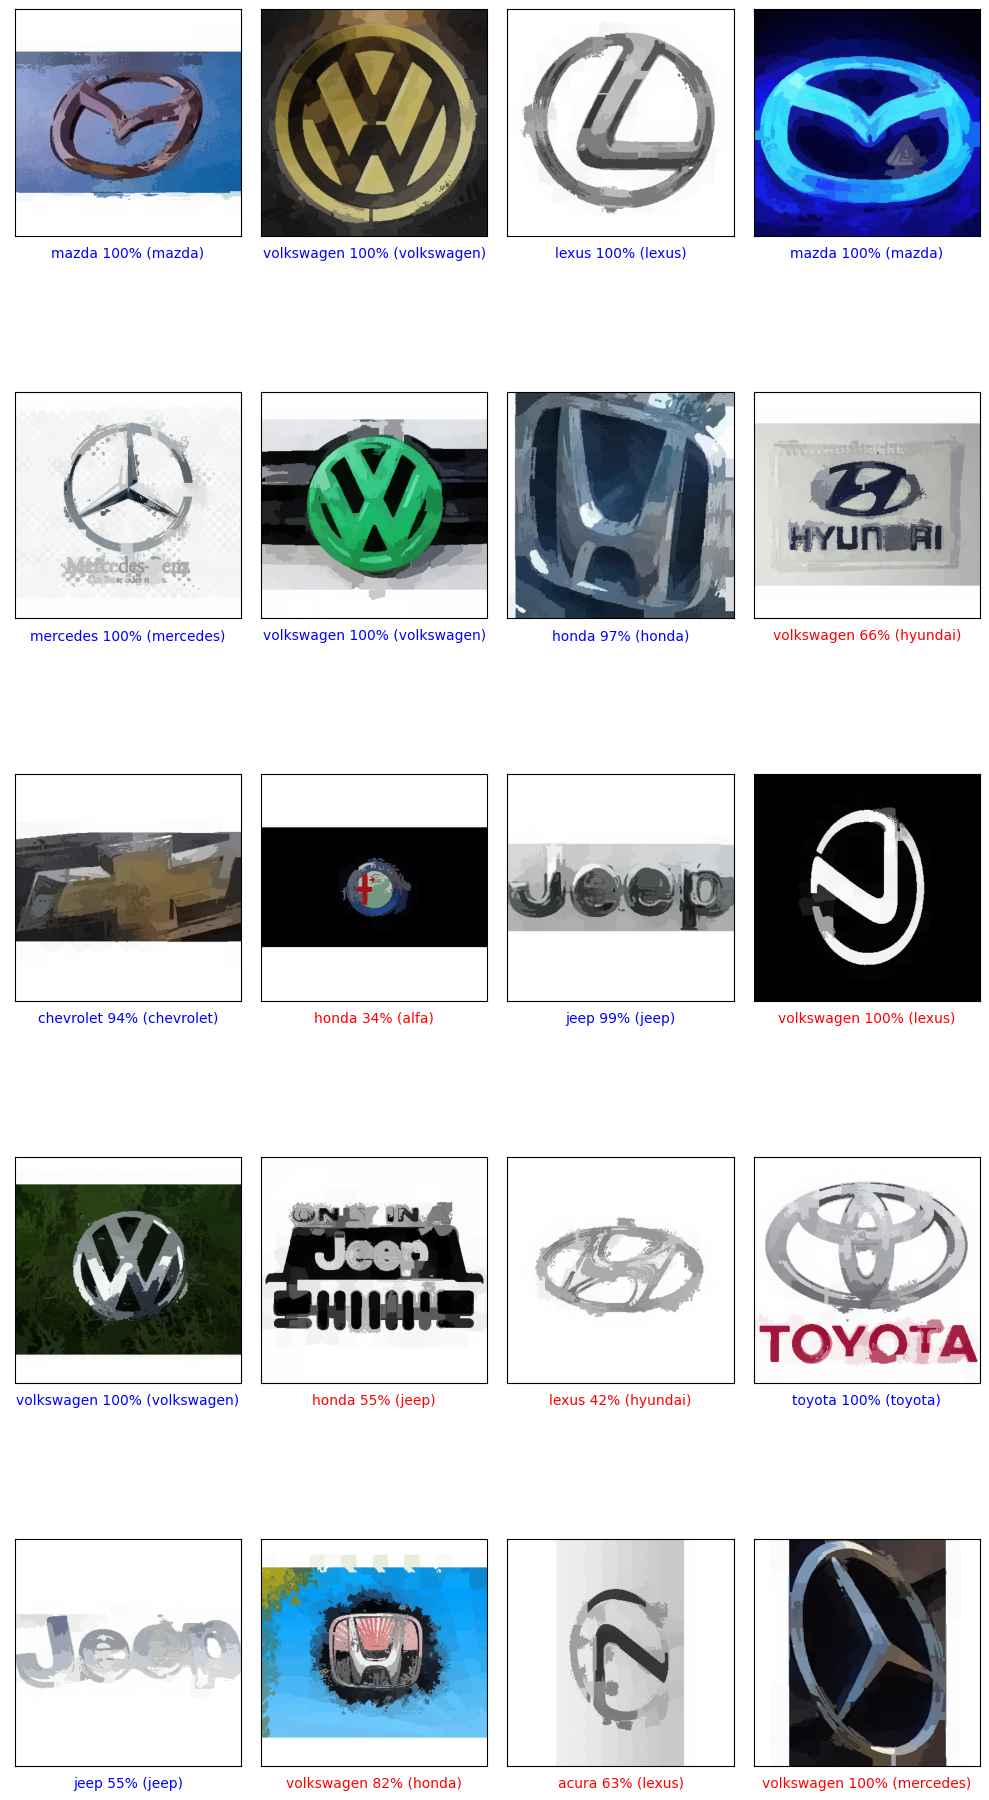

In [179]:
val_batches = tf.data.experimental.cardinality(val_ds)
# Take a fraction for testing
test_dataset = val_ds.take(val_batches // 5).unbatch().batch(1)

# Shuffle the test dataset and take 20 random samples
test_dataset = test_dataset.shuffle(buffer_size=100).take(20)

# Class names
class_names = train_ds.class_names

# Plotting function


def plot_image(prediction_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"))

    predicted_label = np.argmax(prediction_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(prediction_array),
                                         class_names[true_label]),
               color=color)


# Make predictions and display the images with labels
plt.figure(figsize=(10, 20))
for i, (image, label) in enumerate(test_dataset):
    prediction = model.predict(image)
    true_label = np.argmax(label.numpy(), axis=1)[0]
    plt.subplot(5, 4, i+1)
    plot_image(prediction[0], true_label, image[0])
plt.tight_layout()
plt.show()
